# Basic feed-forward ANN model

**The Human Activity Recognition dataset is specifically for multi-class classification tasks. The input is *multivariate* time series, using a format not seen before. The dataset can also be found on Kaggle website.**

**The data comes from real experiments on real people who performed specific activities whilst wearing a smartphone. The six activities were:**

    WALKING
    WALKING_UPSTAIRS
    WALKING_DOWNSTAIRS
    SITTING
    STANDING
    LAYING

**These activities are the classes you are trying to predict.**

**The sensors on the smartphone measure linear acceleration and angular velocity, from which come multiple *features* or time series. For example, two types of acceleration - total acceleration and body acceleration. According to the documentation, the body acceleration is calculated by subtracting gravity from the total acceleration.** 

**The input data you are going to use has nine time series in total:**

    3 XYZ time series for total acceleration
    3 XYZ time series for body acceleration
    3 XYZ time series for angular velocity
    
**Each time series is recorded at 50 Hertz (Hz), meaning 50 measurements per second, and the total duration for each sample is 2.56 seconds. This means there are 128 measurements for each sample, i.e. the length of each time series corresponding to some activity is 128. You are not using the raw time series, but the pre-processed time series, which has noise removed, low-pass filtering and min-max scaling applied (so standardization not needed).**

**In summary, the input data has the shape *N* x *T* x *D*, where *N* is the number of samples (in the thousands - see the data files), *T* is the number of timesteps (128), and *D* is the input dimensions or features (9).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

%matplotlib inline

## Data Exploration

In [2]:
from os import listdir

dir_path = 'data/UCI-HAR/UCI HAR Dataset'

res = listdir(dir_path)
print(res)

['.DS_Store', 'activity_labels.txt', 'features.txt', 'features_info.txt', 'README.txt', 'test', 'train']


**The text files contain information and metadata about the dataset, like the total number of features. The actual data is stored in the `train` and `test` folders. The data is formatted in text files, so can be loaded in Pandas using `pd.read_csv()` function. All the time series in each `Inertial Signals` folder are the same length**

**NOTE: The text files do not have any column names, i.e. no header information. Make sure to include `header=None` when loading the files in Pandas. Also, each value is separated by whitespace, so make sure to include `delim_whitespace=True` to separate each value into its own row.**

In [3]:
listdir('data/UCI-HAR/UCI HAR Dataset/train')

['Inertial Signals', 'subject_train.txt', 'X_train.txt', 'y_train.txt']

**The `X_train` file is the training set containing row-per-sample data with multiple columns or *features* (tabular). The `y_train` file contains the corresponding labels (list of integers 1-6).**

**The `subject_train.txt` file is not important unless you want to identify which subject corresponds to what sample.**

**The `Inertial Signals` folder contains the individual nine time series, i.e. nine text files containing the 128 measurements for each sample along the rows, so each column is a measurement of an activity at a point in time for a specific feature, e.g. X time series for body acceleration.**

In [4]:
df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', 
                 header=None, 
                 delim_whitespace=True)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [6]:
# i.e. 7,352 samples for body acceleration time series (7,352 x 128)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 7.2 MB


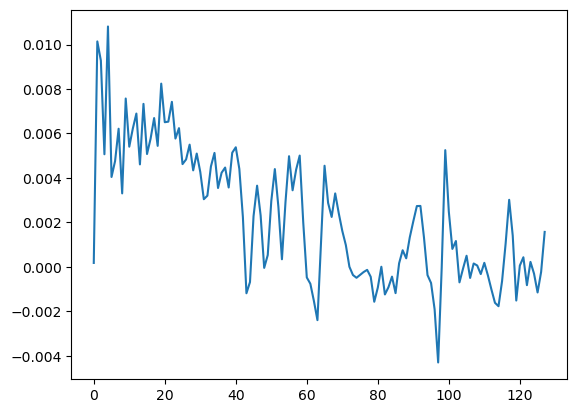

In [7]:
# Plot 1st sample in time series of its 128 recorded body acceleration measurements

df.iloc[0].plot();

**Define important constants in relation to the collection of time series. All information can be accessed by reading the files.**

    T - number of timesteps (128)
    N - number of samples (7,352 for training set; 2,947 for test set)
    D - number of time series (9)
    K - number of class outcomes (6)

In [8]:
# No of timesteps
T = 128

# Length of training set
Ntrain = 7352

# Length of test set
Ntest = 2947

# No of dimensions/time series
D = 9 

# No of classes (1-6)
K = 6 

In [9]:
# Function to load & combine nine time series into training and test sets for ANN

def load_data():
    # Returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    # Training set
    ts_filenames = ['body_acc_x_train.txt', 
                    'body_gyro_x_train.txt', 
                    'total_acc_x_train.txt', 
                    'body_acc_y_train.txt', 
                    'body_gyro_y_train.txt', 
                    'total_acc_y_train.txt', 
                    'body_acc_z_train.txt', 
                    'body_gyro_z_train.txt', 
                    'total_acc_z_train.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/train/' 
    
    # Loop through filenames and convert to arrays
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntrain x T
        x = df.to_numpy()
        # Add D
        Xtrain[:, :, d] = x
        
    # Training labels
    Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1 
    Ytrain = Ytrain.flatten()
    
    # Test set
    ts_filenames = ['body_acc_x_test.txt', 
                    'body_gyro_x_test.txt', 
                    'total_acc_x_test.txt', 
                    'body_acc_y_test.txt', 
                    'body_gyro_y_test.txt', 
                    'total_acc_y_test.txt', 
                    'body_acc_z_test.txt', 
                    'body_gyro_z_test.txt', 
                    'total_acc_z_test.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/test/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntest x T
        x = df.to_numpy()
        # Add D
        Xtest[:, :, d] = x
        
    # Test labels
    Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1 
    Ytest = Ytest.flatten()
    
    return Xtrain, Ytrain, Xtest, Ytest

In [10]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

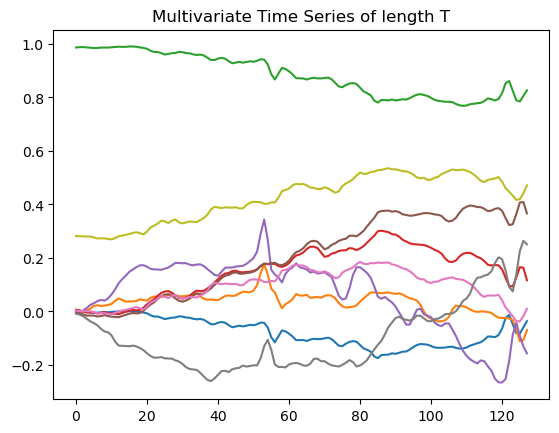

In [12]:
# Plot all nine time series of length T for a single sample (6,999th sample)

plt.plot(Xtrain[7000, :, :])
plt.title("Multivariate Time Series of length T");

**This is an overview of all time series at once, for a single individual, so you get a sense of what the data looks like**

In [13]:
Xtrain[7000, :, :].shape

(128, 9)

In [14]:
# N x T x D

Xtrain.shape

(7352, 128, 9)

## Build multi-tailed ANN classification model

**When dealing with multivariate time series, you build a multi-tailed ANN model, which is basically changing the single input with a list of inputs whenever asked. Each time series has its own mini neural network, and the results are concatenated into one large feature vector before being classified in the final layer.**

In [15]:
inputs = []

# Output of each mini network
features = []

# Make neural network for each time series (D)
for d in range(D):
    i = Input(shape=(T,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    inputs.append(i)
    features.append(x)

# Output of concatenated vectors will be D * 16 (size of individual ANN output)
x = Concatenate()(features)

x = Dense(K)(x)

model = Model(inputs, x)

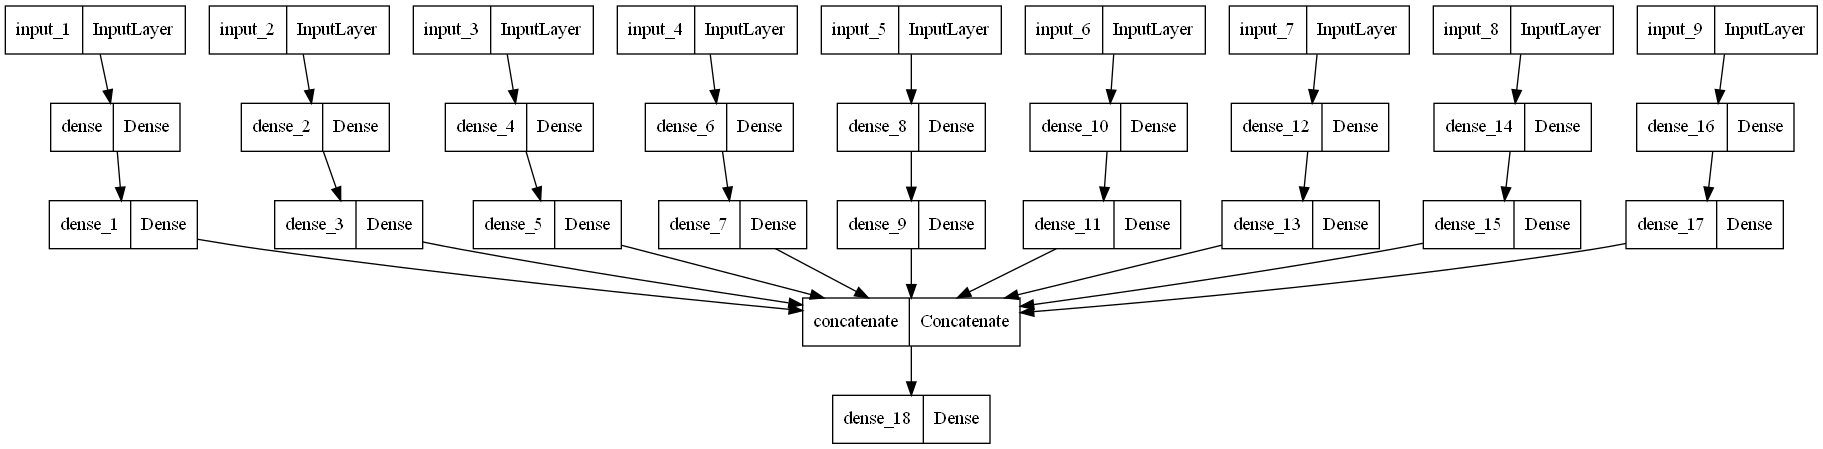

In [16]:
tf.keras.utils.plot_model(model)

In [17]:
# Create checkpoint according to best accuracy - best_model will appear in data folder

check_point = ModelCheckpoint('data/best_model.h5', monitor='val_accuracy', save_best_only=True)

In [18]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=['accuracy'])

**NOTE:**

**You need to convert the input to an acceptable format for TensorFlow's multi-tailed ANN model. Separate out the multivariate nine time series to get a list of univariate time series, so that you pass in a list of inputs to train each mini neural network.**

In [19]:
Xtrain_split = []

Xtest_split = []

for d in range(D):
    Xtrain_split.append(Xtrain[:, :, d])
    Xtest_split.append(Xtest[:, :, d])

In [20]:
r = model.fit(Xtrain_split, 
              Ytrain, 
              epochs=15, 
              callbacks=[check_point], 
              validation_data=(Xtest_split, Ytest))

Epoch 1/15
230/230 [==============================] - 3s 4ms/step - loss: 0.6914 - accuracy: 0.7613 - val_loss: 0.4648 - val_accuracy: 0.8398
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 0.2262 - accuracy: 0.9227 - val_loss: 0.3318 - val_accuracy: 0.8680
Epoch 3/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1578 - accuracy: 0.9472 - val_loss: 0.2907 - val_accuracy: 0.8873
Epoch 4/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1296 - accuracy: 0.9539 - val_loss: 0.2786 - val_accuracy: 0.9002
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1152 - accuracy: 0.9612 - val_loss: 0.2482 - val_accuracy: 0.9070
Epoch 6/15
230/230 [==============================] - 1s 2ms/step - loss: 0.1028 - accuracy: 0.9648 - val_loss: 0.2515 - val_accuracy: 0.9019
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0952 - accuracy: 0.9669 - val_loss: 0.2491 - val_accuracy: 0.9091
Epoch 

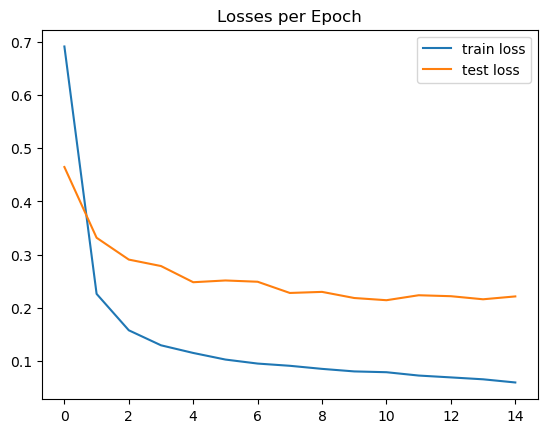

In [21]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

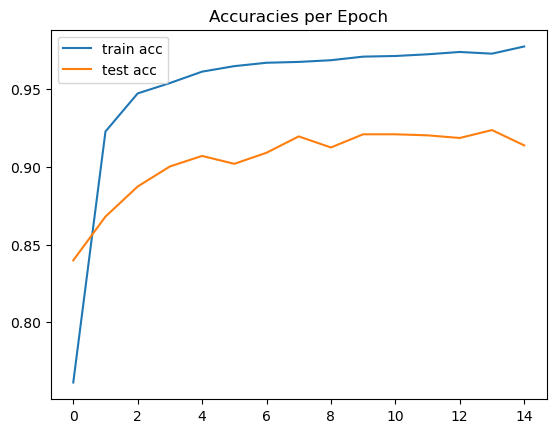

In [22]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracies per Epoch")
plt.legend();

**For both losses and accuracy, the training set performs much better than usual. The test losses do decrease but not as much.**

In [23]:
# Load best multi-tailed model

best_model = tf.keras.models.load_model('data/best_model.h5')

In [24]:
# Make predictions with best model - Ptest is matrix of probabilities per class

Ptest = best_model.predict(Xtest_split)

93/93 [==============================] - 0s 1ms/step


In [25]:
# Evaluate best model (accuracy)

np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9236511706820495

**The model accuracy for multi-tailed ANN is pretty high, at approx. 92%, but you do not have anything to compare with.**

## Compare to feature-based ANN

**The goal is to check how well the model performs using only *static features*, i.e. not multivariate time series but features derived from the time series - similar to traditional machine-learning - so you only need to load the `X_train.txt` and `X_test.txt` files (Ytrain and Ytest can stay the same).** 

**NOTE: It is recommended to standardize the inputs (or features) for neural networks.** 

In [26]:
# Function to standardize features in training and test set

from sklearn.preprocessing import StandardScaler

def load_features():
    # Returns:
    # X_train (Ntrain x D)
    # X_test (Ntest x D)
    
    # Training set
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
    
    feat_train = df.to_numpy()
    
    # Test set
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
    
    feat_test = df.to_numpy()
    
    # Standardize features
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)
    
    return feat_train, feat_test

In [27]:
feat_train, feat_test = load_features()

In [28]:
# Standardized training set (N x D) - 561 features in total

feat_train.shape

(7352, 561)

In [29]:
D_feat = feat_train.shape[1]

In [30]:
i = Input(shape=(D_feat,))

x = Dense(32, activation='relu')(i)

x = Dense(K)(x)

model = Model(i, x)

In [31]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=['accuracy'])

In [32]:
# Create checkpoint based on accuracy - see in data folder

check_point2 = ModelCheckpoint('data/best_model_basic.h5', monitor='val_accuracy', save_best_only=True)

In [33]:
r = model.fit(feat_train, 
              Ytrain, 
              epochs=15, 
              callbacks=[check_point2], 
              validation_data=(feat_test, Ytest))

Epoch 1/15
230/230 [==============================] - 1s 2ms/step - loss: 0.3253 - accuracy: 0.8804 - val_loss: 0.2059 - val_accuracy: 0.9284
Epoch 2/15
230/230 [==============================] - 0s 2ms/step - loss: 0.1051 - accuracy: 0.9663 - val_loss: 0.1630 - val_accuracy: 0.9389
Epoch 3/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.9723 - val_loss: 0.1617 - val_accuracy: 0.9386
Epoch 4/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0.9788 - val_loss: 0.1780 - val_accuracy: 0.9345
Epoch 5/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9818 - val_loss: 0.1723 - val_accuracy: 0.9376
Epoch 6/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9839 - val_loss: 0.1767 - val_accuracy: 0.9372
Epoch 7/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9838 - val_loss: 0.1989 - val_accuracy: 0.9355
Epoch 

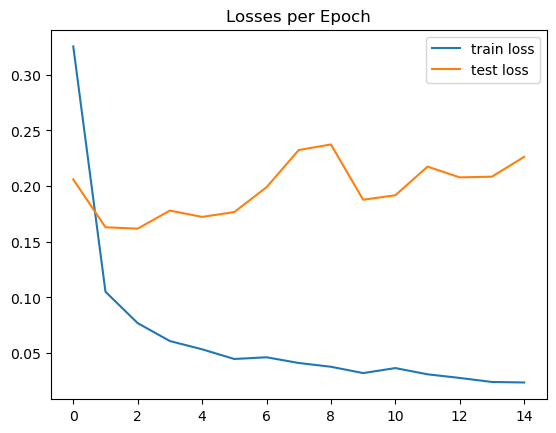

In [34]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

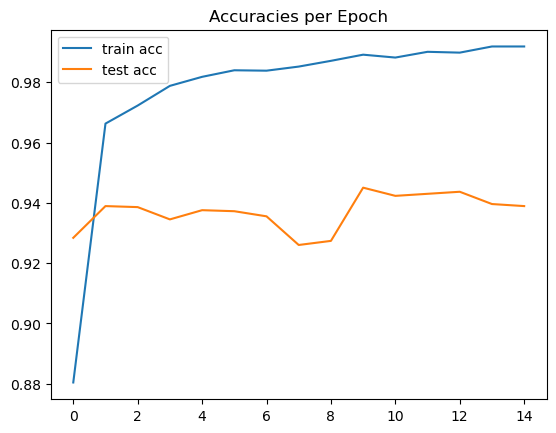

In [35]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracies per Epoch")
plt.legend();

**Even though the losses do not decrease steadily for the basic model, the test loss values are below what was seen in multi-tailed ANN, and test accuracy is also higher than what is seen in multi-tailed ANN. Again the training set greatly outperforms.**

In [36]:
# Load best basic model

best_model = tf.keras.models.load_model('data/best_model_basic.h5')

In [37]:
# Make predictions

Ptest = best_model.predict(feat_test)

93/93 [==============================] - 0s 996us/step


In [38]:
# Evaluate

np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9450288428910757

**The basic model accuracy is higher than the multi-tailed ANN by approx. 2%, showing that using the features led to better performance...**

## Compare to SciKit machine-learning

**You can run the new standardized inputs with the Ytrain and Ytest data through the SciKit-Learn models, same as with feature-based TensorFlow in the previous section.**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Logistic Regression

model = LogisticRegression(solver='liblinear')

model.fit(feat_train, Ytrain)

model.score(feat_train, Ytrain)

0.9945593035908596

In [41]:
print("Logistic Regression Test Accuracy:", model.score(feat_test, Ytest))

Logistic Regression Test Accuracy: 0.9613165931455717


**Logistic Regression scores on feature-based data even better than the feature-based ANN model. This suggests that the data may be linearly separable, i.e. close to a linear decision boundary.**

In [42]:
# Support Vector Machine

model = SVC()

model.fit(feat_train, Ytrain)

model.score(feat_train, Ytrain)

0.9866702937976061

In [43]:
print("Support Vector Test Accuracy:", model.score(feat_test, Ytest))

Support Vector Test Accuracy: 0.9521547336274178


In [44]:
# Linear Support Vector Machine

model = LinearSVC(dual='auto', max_iter=100000)

model.fit(feat_train, Ytrain)

model.score(feat_train, Ytrain)

0.9975516866158868

In [45]:
print("Linear Support Vector Test Accuracy:", model.score(feat_test, Ytest))

Linear Support Vector Test Accuracy: 0.9606379368849678


**Confirming our suspicions, the linear Support Vector Machine performs as well as Logistic Regression. Lets try with a non-linear classifier, like Random Forest.**

In [46]:
# Random Forest

model = RandomForestClassifier()

model.fit(feat_train, Ytrain)

model.score(feat_train, Ytrain)

1.0

In [47]:
print("Random Forest Test Accuracy:", model.score(feat_test, Ytest))

Random Forest Test Accuracy: 0.9307770614183916


**The test accuracy with Random Forest is not as good as Logistic Regression or Linear SVC, even though the training set scored perfectly - but this is misleading as Random Forest often scores perfect on the training set.**

**Results so far show that feature engineering is very useful in practical situations and you can learn much more about the data. Don't discount linear models!**

## Combine multi-tailed ANN with feature-based ANN

**Another way to build a neural network is to combine the multivariate time series ANN with the feature-based ANN.**

**The multivariate time series are looped through to make a multi-tailed ANN, and then a separate input object is created for the feature-based ANN, i.e. its own mini neural network. Both the multi-tailed ANN and the feature-based ANN are concatenated before pushing through the final layer that classifies the samples. You are basically combining different data sources into one big neural network.**

**NOTE: In Python, list1 + list2 = list1+2, i.e. mathematically adding two lists puts them together into one list.**

In [48]:
inputs = []

features = []

# Make neural network for each of the D time series
for d in range(D):
    i = Input(shape=(T,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    inputs.append(i)
    features.append(x)

# Make neural network for feature-based data
i2 = Input(shape=(D_feat,))

x2 = Dense(32, activation='relu')(i2)

# Output will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])

x = Dense(K)(x)

model = Model(inputs + [i2], x)

In [49]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=['accuracy'])

In [50]:
# Create checkpoint based on accuracy - see in data folder

check_point3 = ModelCheckpoint('data/best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [51]:
r = model.fit(Xtrain_split + [feat_train], 
              Ytrain, 
              epochs=15, 
              callbacks=[check_point3], 
              validation_data=(Xtest_split + [feat_test], Ytest))

Epoch 1/15
230/230 [==============================] - 3s 4ms/step - loss: 0.2878 - accuracy: 0.9021 - val_loss: 0.2209 - val_accuracy: 0.9206
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0935 - accuracy: 0.9689 - val_loss: 0.1868 - val_accuracy: 0.9335
Epoch 3/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0683 - accuracy: 0.9761 - val_loss: 0.1765 - val_accuracy: 0.9386
Epoch 4/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0570 - accuracy: 0.9797 - val_loss: 0.1830 - val_accuracy: 0.9399
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.1528 - val_accuracy: 0.9437
Epoch 6/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0403 - accuracy: 0.9867 - val_loss: 0.1676 - val_accuracy: 0.9460
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.1801 - val_accuracy: 0.9477
Epoch 

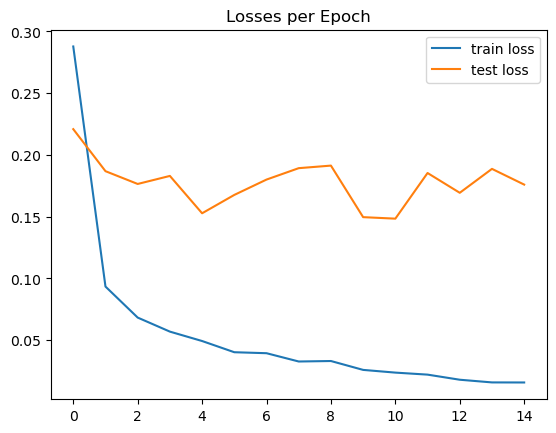

In [52]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

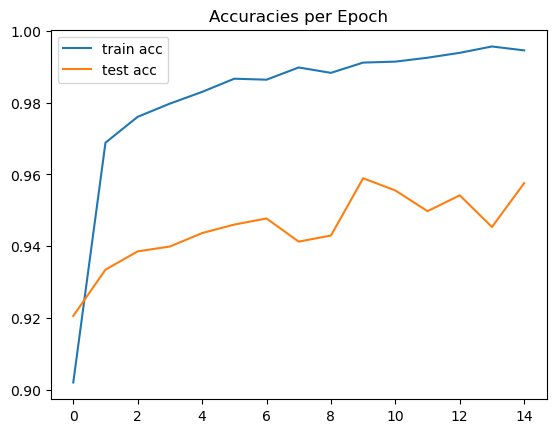

In [53]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracies per Epoch")
plt.legend();

**Nothing out of the ordinary, although it more resembles the feature-based ANN, with lower test errors and higher test accuracy.**

In [54]:
# load best combined model

best_model = tf.keras.models.load_model('data/best_model_combined.h5')

In [55]:
# Make predictions

Ptest = best_model.predict(Xtest_split + [feat_test])

93/93 [==============================] - 0s 1ms/step


In [56]:
# Evaluate

np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9589412962334578

**As we suspected, the combined model performs as well as the feature-based ANN, however, it still does not perform as well as the linear SciKit models, which learned from the static features only.**